In [3]:
import tensorflow as tf
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import cv2
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random
import pickle
import tensorflow_hub as hub

In [4]:
label = ["nose", "left eye", "right eye", "left ear", "right ear", "left shoulder", "right shoulder", "left elbow", "right elbow", "left wrist", "right wrist", "left hip", "right hip", "left knee", "right knee", "left ankle", "right ankle"]

In [14]:
image_path = 'max_standing.jpg'
image = tf.io.read_file(image_path)
image = tf.compat.v1.image.decode_jpeg(image)
X = tf.expand_dims(image, axis=0)
X = tf.cast(tf.image.resize_with_pad(X, 256, 256), dtype=tf.int32)

In [6]:
model = hub.load("https://www.kaggle.com/models/google/movenet/TensorFlow2/multipose-lightning/1")
movenet = model.signatures['serving_default']

In [15]:
outputs = movenet(X)
keypoints = outputs['output_0'].numpy()

In [16]:
keypoints.shape


(1, 6, 56)

In [17]:
max_key,key_val = keypoints[0,:,55].argmax(),keypoints[0,:,55].max()
max_key,key_val

(0, 0.7952771)

In [18]:
max_points = keypoints[0,max_key,:]
max_points = max_points*256
max_points = max_points.astype(float)
max_points

array([ 36.53805161, 121.28870392, 186.25645447,  32.74814606,
       126.45993042, 185.47491455,  33.22895813, 116.90686035,
       202.79220581,  37.22655487, 133.05485535, 212.17480469,
        37.64109421, 111.8086319 , 183.64422607,  67.03931427,
       144.22146606, 216.79714966,  67.48906708, 102.03925323,
       227.43939209,  99.98415375, 150.27522278, 227.35493469,
       101.94764709,  96.08473206, 212.37562561, 129.58721924,
       154.3104248 , 217.63548279, 133.46578979,  88.32936096,
       203.59724426, 130.93814087, 135.55737305, 217.68389893,
       132.66288757, 110.79836273, 230.57373047, 170.83992004,
       137.93173218, 217.29260254, 173.01977539, 110.53556061,
       233.48681641, 209.90164185, 138.4752655 , 233.48535156,
       212.17938232, 110.37792206, 230.82395935,  14.86979675,
        83.73782349, 234.60009766, 159.60929871, 203.59094238])

In [19]:
keypoints_dict = {}
for i in range(0,len(max_points)-5,3):
    keypoints_dict[label[i//3]] = [max_points[i],max_points[i+1],max_points[i+2]]

In [20]:
import math

In [21]:
keypoints_dict

{'nose': [36.53805160522461, 121.28870391845703, 186.25645446777344],
 'left eye': [32.748146057128906, 126.45993041992188, 185.47491455078125],
 'right eye': [33.22895812988281, 116.9068603515625, 202.79220581054688],
 'left ear': [37.22655487060547, 133.0548553466797, 212.1748046875],
 'right ear': [37.64109420776367, 111.80863189697266, 183.64422607421875],
 'left shoulder': [67.03931427001953, 144.22146606445312, 216.79714965820312],
 'right shoulder': [67.48906707763672, 102.03925323486328, 227.43939208984375],
 'left elbow': [99.9841537475586, 150.2752227783203, 227.3549346923828],
 'right elbow': [101.94764709472656, 96.08473205566406, 212.37562561035156],
 'left wrist': [129.58721923828125, 154.3104248046875, 217.63548278808594],
 'right wrist': [133.46578979492188, 88.32936096191406, 203.5972442626953],
 'left hip': [130.93814086914062, 135.557373046875, 217.68389892578125],
 'right hip': [132.6628875732422, 110.7983627319336, 230.57373046875],
 'left knee': [170.8399200439453

In [68]:
left_hip = keypoints_dict['left hip'][:-1]
left_knee = keypoints_dict['left knee'][:-1]
left_ankle = keypoints_dict['left ankle'][:-1]

right_hip = keypoints_dict['right hip'][:-1]
right_knee = keypoints_dict['right knee'][:-1]
right_ankle = keypoints_dict['right ankle'][:-1]


In [45]:
print(left_ankle,left_knee,left_hip)

[209.90164184570312, 138.4752655029297] [170.8399200439453, 137.93173217773438] [130.93814086914062, 135.557373046875]


In [70]:
y1 = left_knee[0]-left_hip[0]
x1 = left_knee[1]-left_hip[1]
y2 = left_ankle[0]-left_knee[0]
x2 = left_ankle[1]-left_knee[1]
l2 = y2/x2
l1 = y1/x1
r2 = (right_ankle[0]-right_knee[0])/(right_ankle[1]-right_knee[1])
r1 = (right_knee[0]-right_hip[0])/(right_knee[1]-right_hip[1])



In [37]:
from math import atan

In [73]:
def findAngle(M1, M2):
    PI = 3.14159265
     
    # Store the tan value  of the angle
    angle = abs((M2 - M1) / (1 + M1 * M2))
    
    # Calculate tan inverse of the angle
    ret = atan(angle)
 
    # Convert the angle from
    # radian to degree
    val = (ret * 180) / PI
    
    # Print the result
    return 180-round(val,4)

In [74]:
angle = findAngle(l2,l1)
ra = findAngle(r2,r1)
print(angle,ra)

177.3918 179.8575


In [26]:
def make_pred(img, keypoints_dict, label):
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.title('Original Image')
    plt.imshow(img[0])
    plt.subplot(1, 3, 2)
    plt.imshow(img[0])
    plt.title('Pose')
    plt.axis('off')
    for i in range(13):
        plt.scatter(keypoints_dict[label[i]][1],keypoints_dict[label[i]][0],color='green')

    connections = [
        ('nose', 'left eye'), ('left eye', 'left ear'), ('nose', 'right eye'), ('right eye', 'right ear'),
        ('nose', 'left shoulder'), ('left shoulder', 'left elbow'), ('left elbow', 'left wrist'),
        ('nose', 'right shoulder'), ('right shoulder', 'right elbow'), ('right elbow', 'right wrist'),
        ('left shoulder', 'left hip'), ('right shoulder', 'right hip'), ('left hip', 'right hip'),
        ('left hip', 'left knee'), ('right hip', 'right knee')
    ]

    for start_key, end_key in connections:
        if start_key in keypoints_dict and end_key in keypoints_dict:
            start_point = keypoints_dict[start_key][:2]  # Take first two values
            end_point = keypoints_dict[end_key][:2]      # Take first two values
            plt.plot([start_point[1], end_point[1]], [start_point[0], end_point[0]], linewidth=2)
    
    plt.subplot(1, 3, 3)
    plt.imshow((img[0]/255)/255)
    plt.title('Only Pose Image')
    for start_key, end_key in connections:
        if start_key in keypoints_dict and end_key in keypoints_dict:
            start_point = keypoints_dict[start_key][:2]  # Take first two values
            end_point = keypoints_dict[end_key][:2]      # Take first two values
            plt.plot([start_point[1], end_point[1]], [start_point[0], end_point[0]], linewidth=2)

In [27]:
img = tf.image.resize_with_pad(image, 256, 256)
img = tf.cast(img, dtype=tf.int32)
img = tf.expand_dims(img, axis=0)
img = img.numpy()

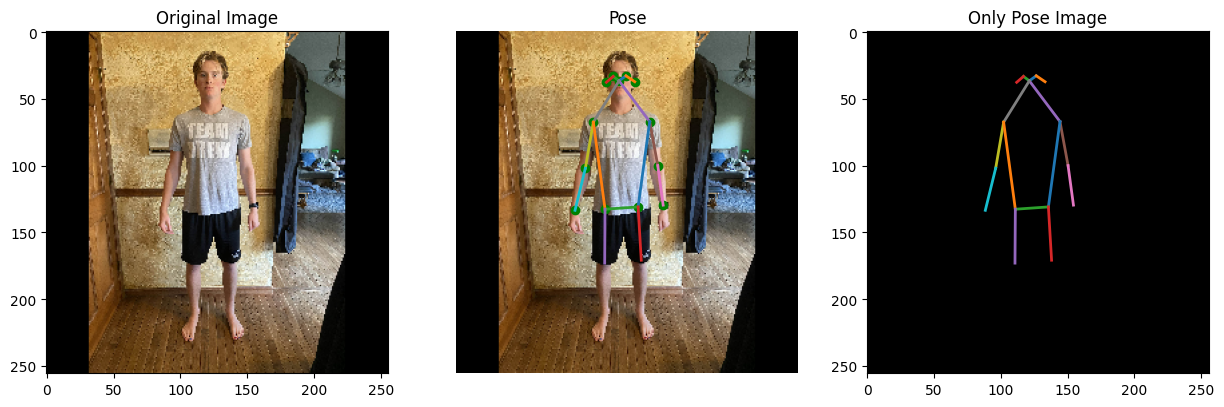

In [28]:
make_pred(img, keypoints_dict, label)
